In [17]:
#imports
from datetime import date, timedelta
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
# get data
url = 'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-{}.xlsx'
latest_date = date.today()
response = requests.get(url.format(latest_date))
if not response:
    latest_date = latest_date - timedelta(days=1)
    response = requests.get(url.format(latest_date))
assert response, 'No data from ECDC!'

In [35]:
# read data
data = pd.read_excel(response.content, 'COVID-19-geographic-disbtributi')

dateRep  day  month  year  cases  deaths countriesAndTerritories  \
0     2020-11-01    1     11  2020     76       0             Afghanistan   
1     2020-10-31   31     10  2020    157       4             Afghanistan   
2     2020-10-30   30     10  2020    123       3             Afghanistan   
3     2020-10-29   29     10  2020      0       0             Afghanistan   
4     2020-10-28   28     10  2020    113       7             Afghanistan   
...          ...  ...    ...   ...    ...     ...                     ...   
52737 2020-03-25   25      3  2020      0       0                Zimbabwe   
52738 2020-03-24   24      3  2020      0       1                Zimbabwe   
52739 2020-03-23   23      3  2020      0       0                Zimbabwe   
52740 2020-03-22   22      3  2020      1       0                Zimbabwe   
52741 2020-03-21   21      3  2020      1       0                Zimbabwe   

      geoId countryterritoryCode  popData2019 continentExp  \
0        AF                  AFG   38041757.0         Asia   
1        AF                  AFG   38041757.0         Asia   
2        AF                  AFG   38041757.0         Asia   
3        AF                  AFG   38041757.0         Asia   
4        AF                  AFG   38041757.0         Asia   
...     ...                  ...          ...          ...   
52737    ZW                  ZWE   14645473.0       Africa   
52738    ZW                  ZWE   14645473.0       Africa   
52739    ZW                  ZWE   14645473.0       Africa   
52740    ZW                  ZWE   14645473.0       Africa   
52741    ZW                  ZWE   14645473.0       Africa   

       Cumulative_number_for_14_days_of_COVID-19_cases_per_100000  
0                                               3.575019           
1                                               3.553989           
2                                               3.264833           
3                                               2.941505           
4                                               3.025623           
...                                                  ...           
52737                                                NaN           
52738                                                NaN           
52739                                                NaN           
52740                                                NaN           
52741                                                NaN           

[52742 rows x 12 columns]

In [4]:
# prepare data
def prepareData(data, countryCode):
    country = data[data.geoId == countryCode]
    country_today = country[country.dateRep == latest_date.strftime('%Y-%m-%d')]['cases'].values[0]
    country = country.groupby('dateRep').cases.sum()
    country = country.groupby(country.index.to_period('y')).cumsum().reset_index()
    country_total = country[country.dateRep == latest_date.strftime('%Y-%m-%d')]['cases'].values[0]
    return country, country_total, country_today

serbia, serbia_total, serbia_today = prepareData(data, 'RS')
ireland, ireland_total, ireland_today = prepareData(data, 'IE')
slovenia, slovenia_total, slovenia_today = prepareData(data, 'SI')

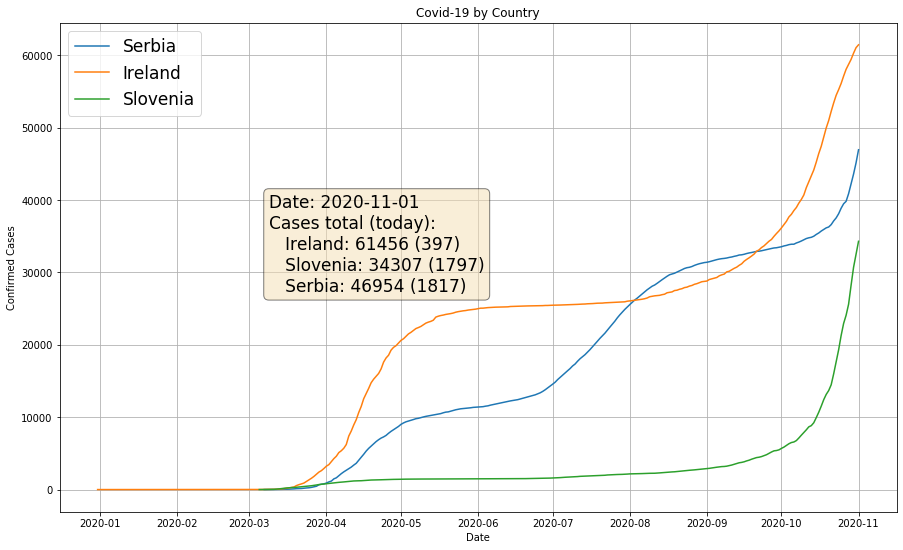

In [5]:
# plot data
fig, ax = plt.subplots(figsize=(15,9))
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title('Covid-19 by Country')
plt.grid(True)
ax.plot(serbia['dateRep'], serbia['cases'], label='Serbia')
ax.plot(ireland['dateRep'], ireland['cases'], label='Ireland')
ax.plot(slovenia['dateRep'], slovenia['cases'], label='Slovenia')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr = '\n'.join((
    'Date: {}'.format(latest_date),
    'Cases total (today):\n'
    '   Ireland: {} ({})'.format(ireland_total, ireland_today),
    '   Slovenia: {} ({})'.format(slovenia_total, slovenia_today),
    '   Serbia: {} ({})'.format(serbia_total, serbia_today),
    )
)
ax.text(0.25, 0.65, textstr, transform=ax.transAxes, fontsize=17,
        verticalalignment='top', bbox=props)

ax.legend(prop={'size': 17})
plt.show()

In [48]:
# new daily cases by country
def newWeeklyCasesByCountry(data, countryCode):
    country = data[data.geoId == countryCode]
    country_today = country[country.dateRep == latest_date.strftime('%Y-%m-%d')]['cases'].values[0]
    country = country.groupby(['geoId', pd.Grouper(key='dateRep', freq='W-MON', label='left')])['cases'].sum().reset_index().sort_values('dateRep')
    return country, country_today

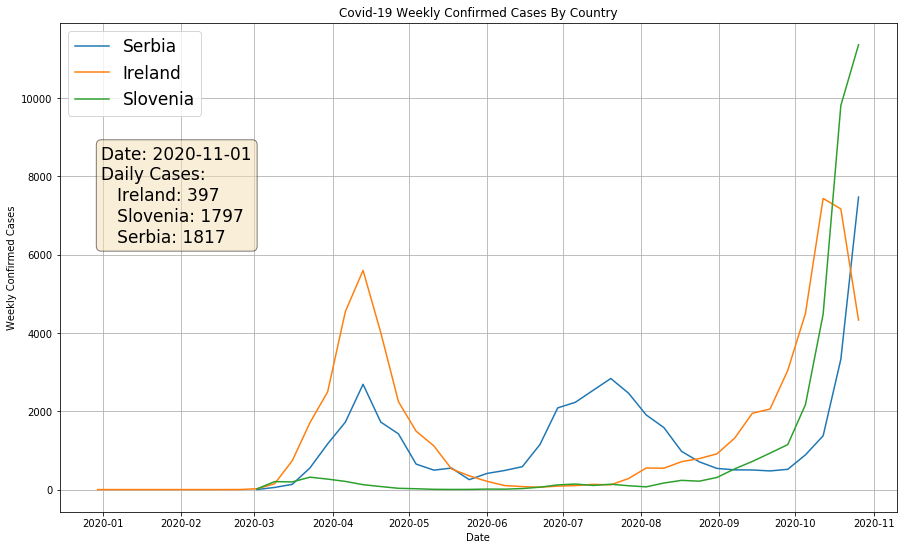

In [54]:
# plot daily cases by country
fig, ax = plt.subplots(figsize=(15,9))
plt.xlabel('Date')
plt.ylabel('Weekly Confirmed Cases')
plt.title('Covid-19 Weekly Confirmed Cases By Country')
plt.grid(True)

serbia, serbia_today = newWeeklyCasesByCountry(data, 'RS')
ireland, ireland_today = newWeeklyCasesByCountry(data, 'IE')
slovenia, slovenia_today = newWeeklyCasesByCountry(data, 'SI')

ax.plot(serbia['dateRep'], serbia['cases'], label='Serbia')
ax.plot(ireland['dateRep'], ireland['cases'], label='Ireland')
ax.plot(slovenia['dateRep'], slovenia['cases'], label='Slovenia')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr = '\n'.join((
    'Date: {}'.format(latest_date),
    'Daily Cases:\n'
    '   Ireland: {}'.format(ireland_today),
    '   Slovenia: {}'.format(slovenia_today),
    '   Serbia: {}'.format(serbia_today),
    )
)
ax.text(0.05, 0.75, textstr, transform=ax.transAxes, fontsize=17,
        verticalalignment='top', bbox=props)

ax.legend(prop={'size': 17})
plt.show()